In [124]:
import tensorflow.compat.v1 as tf
import numpy as np
import gym, time
import matplotlib.pyplot as plt
from gym.envs.toy_text.frozen_lake import generate_random_map

tf.set_random_seed(1)
np.random.seed(1)
tf.compat.v1.disable_eager_execution()
tf.reset_default_graph()

In [127]:
# the main DQN agent class. this implements all the methods needed for model init, training
# and running the frozen lake simulation
class DeepQNetwork:
    # initialize all member variables, tensorflow networks
    def __init__(self, learning_rate=0.0012, decay_rate=0.001, gamma=0.98):
        self.session = tf.Session()
        self.memory_counter = 0 # used to keep track of the number of memory experiences
        self.batch_size = 64 # 
        self.learning_rate = learning_rate # model learning rate, from 0-1
        self.epsilon = 1.0 # exploration rate
        self.max_epsilon = 1.0 # exploration rate at the beginning of training
        self.min_epsilon = 0.1 # minimum exploration probability
        self.decay_rate = decay_rate # exponential decay rate for exploration probability
        self.gamma = gamma # model discounting rate
        self.max_steps = 500 # max steps per episode to avoid getting stuck
        self.memory_capacity = 10_000 
        self.memory = np.zeros((self.memory_capacity, state_size * 2 + 2))  # initialize memory
        self.update_interval = 150 # interval to update the model on the current memory values

        # build the computation graph with placeholder data structures. data will be fed into the graph later
        self.state = tf.placeholder(tf.float64, [None, state_size]) # current environment state
        self.action = tf.placeholder(tf.int32, [None, ]) # state for the chosen action
        self.reward = tf.placeholder(tf.float64, [None, ]) # state for the received reward
        self.state_next = tf.placeholder(tf.float64, [None, state_size]) # placeholder for the next environment state

        # create the DQN evaluation network as "q" which takes the current state (self.state) as input
        # this network has one hidden layer with 10 units and ReLU activation
        with tf.variable_scope('q'):
            l_eval = tf.layers.dense(self.state, 10, tf.nn.relu,
                                     kernel_initializer=tf.random_normal_initializer(0, 0.1))
            self.q = tf.layers.dense(l_eval, action_size, kernel_initializer=tf.random_normal_initializer(0, 0.1))

        # create the DQN target network as "q_next". this has the same architecture as the evaluation network but 
        # with trainable parameters set to "false". This network is used for calculating the target Q-values during training. 
        with tf.variable_scope('q_next'):  # target network, not to train
            l_target = tf.layers.dense(self.state_next, 10, tf.nn.relu, trainable=False)
            q_next = tf.layers.dense(l_target, action_size, trainable=False)

        # q_next represents calculates the Q-value for the next state (state_next) using the target network constructed above.
        # q_target is the target Q-value, calculated as the sum of the immediate reward (self.reward) and the discounted maximum
        # Q-value of the next state
        q_target = self.reward + self.gamma * tf.reduce_max(q_next, axis=1)
        a_index = tf.stack([tf.range(self.batch_size, dtype=tf.int32), self.action], axis=1)
        # the Q-value of the chosen action from the evaluation network. this is done using tf.gather_nd to select the Q-value
        # corresponding to the chosen action.
        q_eval = tf.gather_nd(params=self.q, indices=a_index)
        # the loss is calculated using mean squared error between the target Q-value (q_target) and the Q-value of
        # the chosen action "q_eval".
        loss = tf.losses.mean_squared_error(q_target, q_eval)
        # we use the adam optimizer to minimize loss, as this adjusts learning rates for each parameter and allows
        # efficient optimization and convergence
        self.optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(loss)
        # init all tensorflow global variables
        self.session.run(tf.global_variables_initializer())

    # the action selection logic for the DQN agent
    def choose_action(self, observation: int) -> int:
        # generate a 1 x state_size numpy array filled with zeros to send to the model
        one_hot = np.zeros((1, state_size)) 
        # set the current observation by its index to 1, making a one-hot vector for better model accuracy
        one_hot[0, observation] = 1.0
        exp_exp_tradeoff = np.random.uniform(0, 1)
        # if the generated uniform random floating point value between 0 and 1 is higher than epsilon
        # then we want to take predicted actions from the DQN model, otherwise, sample a random action
        # from the action space.
        if exp_exp_tradeoff > self.epsilon:
            # query model for prediction
            action = np.argmax(self.session.run(self.q, feed_dict={self.state: one_hot}))
        else:
            # return random sample from the action space
            action = np.random.randint(0, action_size)
        return action

    # learning function for the dqn agent. learns in batches and then samples randomly 
    # from the replay memory
    def learn(self) -> None:
        # update the target network with the parameters from the evaluation network
        # this is done every update_interval experiences
        if self.memory_counter % self.update_interval == 0:
            t_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='q_next')
            e_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='q')
            self.session.run([tf.assign(t, e) for t, e in zip(t_params, e_params)])
        # randomly sample a mini batch of experiences from the replay memory
        rand_indexes = np.random.choice(self.memory_capacity, self.batch_size, replace=False)
        temp = self.memory[rand_indexes]

        # extract the components from the batch
        batch_state = temp[:, 0:state_size]
        batch_action = temp[:, state_size]
        batch_reward = temp[:, state_size + 1]
        batch_state_next = temp[:, state_size + 2:]

        # constructs a feed dictionary to provide the batch data to the 
        # tensorFlow placeholders in the dqn model
        feed = {self.state: batch_state, self.action: batch_action, self.reward: batch_reward, self.state_next: batch_state_next}
        self.session.run(self.optimizer, feed_dict=feed)

    # this function pushes an entire experience to memory with all state variables needed for batch training
    def push_experience_to_memory(self, observation: int, action: int, reward: int, observation_: int) -> None:
        # generate a state_size numpy array filled with zeros for pushing into memory
        one_hot = np.zeros(state_size)
        one_hot[observation] = 1.0 # set the current observation as the active state
        # do the same for the next observation
        one_hot_next = np.zeros(state_size)
        one_hot_next[observation_] = 1.0 # set the current observation as the active state
        # push the experience to memory and increment the memory counter
        self.memory[self.memory_counter % self.memory_capacity] = np.hstack([one_hot, action, reward, one_hot_next])
        self.memory_counter += 1

    # the main training loop
    def run_train(self, episodes: int) -> None:
        cnt_win = 0
        all_r = 0.0
        win_rate = []
        last_50_eps = 0
        # train for the passed number of episodes
        for episode in range(episodes):
            epsilon_per_episode[episode] = self.epsilon
            observation = env.reset()[0]
            steps = 0
            done = False
            while not done and steps < self.max_steps:
                # choose an action with our action selection logic
                action = self.choose_action(observation)
                # get the new observation for that action
                observation_, reward, term, trunc, info = env.step(action)
                # if we hit the goal, record this event
                if reward == 1:
                    reward = 5
                    all_r += 1
                    cnt_win += 1.0
                    last_50_eps += 1
                    rewards_per_episode[episode] = 1

                # push action and results to memory cache
                self.push_experience_to_memory(observation, action, reward, observation_)
                # only learn if the memory is full?
                if self.memory_counter > self.memory_capacity:
                    self.learn()
                # set the last state as the new observation
                observation = observation_
                steps += 1
                # make sure to keep track if the episode should end by termination or too many steps
                done = term or trunc

            # only reduce epsilon at 50 episode intervals
            if episode % 50 == 0:
                print(f"Episode: {episode} - Steps: {steps} - Wins: {cnt_win}({cnt_win / 50})")
                # exponentially decay epsilon based on the decay rate
                self.epsilon = self.min_epsilon + (self.max_epsilon - self.min_epsilon) * np.exp(
                        -self.decay_rate * episode)
                print(f"Epsilon: {self.epsilon}")

                # print the model accuracy at this 50th episode interval
                print("current accuracy: %.2f %%" % (cnt_win / 50.0 * 100))
                win_rate.append(cnt_win / 50)
                cnt_win = 0
                # keep track of the global accuracy as training progresses
                print("Global accuracy : %.2f %%" % (all_r / (episode + 1) * 100))

        print("Global accuracy : ", all_r / episodes * 100, "%")

    # test the trained model by running the environment and using the model to predict actions
    def run_test(self, episodes: int) -> None:
        for ep in range(episodes):  # episode loop
            observation = env.reset()[0]  # reset env for new episode
            done = False  # flag for detecting end of episode
            while not done:  # loop until we either find the goal or fail (fall into hole)
                action = self.choose_action(observation)  # choose action from model prediction
                observation, reward, term, trunc, info = env.step(action)  # step agent
                done = term or trunc  # check if we need to stop this episode
                if done and reward == 1:  # if we need to stop episode, and we found the goal, print debug
                    print("GOAL")

C:\Users\Admin\AppData\Local\Temp\ipykernel_6420\4100482670.py:29: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  l_eval = tf.layers.dense(self.state, 10, tf.nn.relu,
C:\Users\Admin\AppData\Local\Temp\ipykernel_6420\4100482670.py:31: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.q = tf.layers.dense(l_eval, action_size, kernel_initializer=tf.random_normal_initializer(0, 0.1))
C:\Users\Admin\AppData\Local\Temp\ipykernel_6420\4100482670.py:36: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  l_target = tf.layers.dense(self.state_next, 10, tf.nn.relu, trainable=False)
C:\Users\Admin\AppData\Local\Temp\ipykernel_6420\4100482670.py:37: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.ke

Episode: 0 - Steps: 10 - Wins: 0(0.0)
Epsilon: 1.0
current accuracy: 0.00 %
Global accuracy : 0.00 %
Episode: 50 - Steps: 19 - Wins: 3.0(0.06)
Epsilon: 0.9821788059760798
current accuracy: 6.00 %
Global accuracy : 5.88 %
Episode: 100 - Steps: 7 - Wins: 5.0(0.1)
Epsilon: 0.9647104952370908
current accuracy: 10.00 %
Global accuracy : 7.92 %
Episode: 150 - Steps: 42 - Wins: 4.0(0.08)
Epsilon: 0.9475880802258239
current accuracy: 8.00 %
Global accuracy : 7.95 %
Episode: 200 - Steps: 3 - Wins: 2.0(0.04)
Epsilon: 0.9308047117479722
current accuracy: 4.00 %
Global accuracy : 6.97 %
Episode: 250 - Steps: 16 - Wins: 7.0(0.14)
Epsilon: 0.9143536762323635
current accuracy: 14.00 %
Global accuracy : 8.37 %
Episode: 300 - Steps: 11 - Wins: 2.0(0.04)
Epsilon: 0.8982283930454418
current accuracy: 4.00 %
Global accuracy : 7.64 %
Episode: 350 - Steps: 9 - Wins: 2.0(0.04)
Epsilon: 0.8824224118589252
current accuracy: 4.00 %
Global accuracy : 7.12 %
Episode: 400 - Steps: 2 - Wins: 2.0(0.04)
Epsilon: 0.86

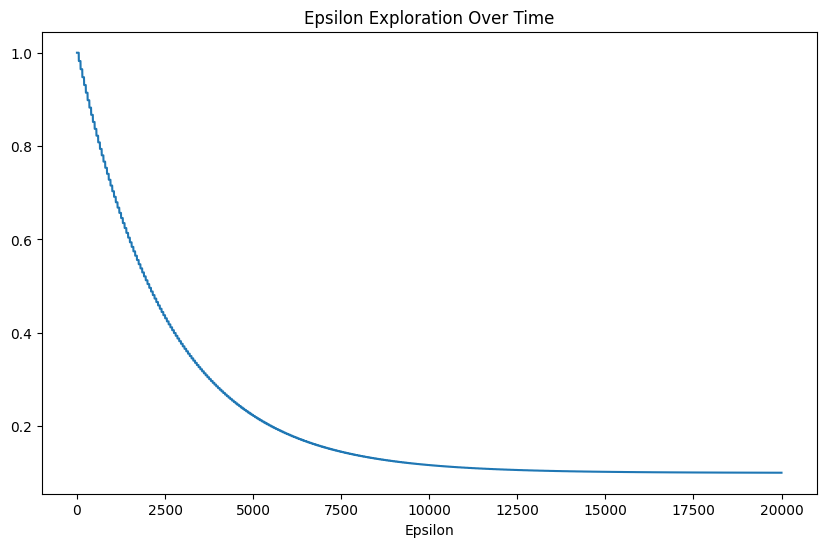

Score over time: 0.0


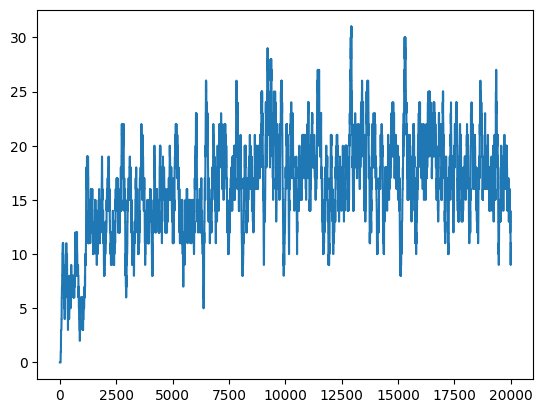

In [126]:
# set up the values needed for graphs
train_episodes = 20000
rewards = []
rewards_per_episode = np.zeros(train_episodes)
epsilon_per_episode = np.zeros(train_episodes)

# generate a random maze map
random_map = generate_random_map(size=4, p=0.3)

# environment setup
env = gym.make('FrozenLake-v1', desc=random_map, is_slippery=True)
env = env.unwrapped
# get the action and state space size
action_size = env.action_space.n
state_size = env.observation_space.n
# construct the DQN agent network
dqn = DeepQNetwork(learning_rate=0.1, decay_rate=0.0004, gamma=0.999)
# train the agent
dqn.run_train(train_episodes)

# generate the figures needed for the report
plt.figure(figsize=(10, 6))
plt.plot(epsilon_per_episode)
plt.title('Epsilon Exploration Over Time')
plt.xlabel('Epsilon')
plt.show()
plt.savefig(f"plt-ep_over_time-ST({state_size})-EP({train_episodes})-L({dqn.learning_rate})-G({dqn.gamma}).png")

sum_rewards = np.zeros(train_episodes)
for t in range(train_episodes):
    sum_rewards[t] = np.sum(rewards_per_episode[max(0, t-100):(t+1)])
plt.plot(sum_rewards)
plt.savefig(f"plt-ST({state_size})-EP({train_episodes})-L({dqn.learning_rate})-G({dqn.gamma}).png")

print("Score over time: " + str(sum(rewards) / train_episodes))